In [2]:
from src.data_loader import UCF101_Dataset_Loader
from src.training import DEVICE
from src.model_architectures import AlexNet3D, VGG3D
from src.utils import plot_confusion_matrix

import torch
import numpy as np

from tqdm import tqdm


from sklearn.metrics import precision_score, recall_score

# Alexnet

In [3]:
ucf_data_dir = "data/UCF101/"
ucf_label_dir = "data/ucfTrainTestlist/"
frames_per_clip = 16
step_between_clips = 1

height = 112
width = 112

batch_size = 256

In [4]:
ucf101 = UCF101_Dataset_Loader(ucf_data_dir, ucf_label_dir, frames_per_clip, step_between_clips, height, width, batch_size)

Loading Training Data .........


100%|██████████| 85/85 [00:22<00:00,  3.81it/s]


Loading Testing Data .........


100%|██████████| 85/85 [00:22<00:00,  3.81it/s]



Total number of train samples: 6633
Total number of test samples: 2532
Total number of (train) batches: 26
Total number of (test) batches: 10


Total Number of Classes: 10


### Without Masking

In [9]:
!  ls cd models

ls: cannot access 'cd': No such file or directory
models:
alex_net_base_data.pth	      vgg_base_data.pth
alex_net_bg_mask_data.pth     vgg_bg_mask_data.pth
alex_net_human_mask_data.pth  vgg_human_mask_data.pth


In [32]:
alex_net_model = AlexNet3D((frames_per_clip, height, width), len(ucf101.classes)).to(device=DEVICE)
alex_net_model.load_state_dict(torch.load('models/alex_net_base_data.pth'))
alex_net_model.train(False)

AlexNet3D(
  (max_pool): MaxPool3d(kernel_size=3, stride=2, padding=(1, 1, 1), dilation=1, ceil_mode=False)
  (conv1): Conv3d(3, 96, kernel_size=(5, 5, 5), stride=(2, 2, 2), padding=(3, 0, 0))
  (conv2): Conv3d(96, 256, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(3, 2, 2))
  (conv3): Conv3d(256, 384, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv4): Conv3d(384, 384, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv5): Conv3d(384, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (linear1): Linear(in_features=100352, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

In [33]:
all_preds = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in tqdm(ucf101.test_loader):
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)
        y_pred_prob = alex_net_model(inputs)
        y_pred = torch.argmax(y_pred_prob, dim=1)
        # Store predictions and true labels
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Convert lists to tensors or numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

100%|██████████| 10/10 [02:52<00:00, 17.28s/it]


In [34]:
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')


print("Precision:", precision)
print("Recall:", recall)

Precision: 0.37519747235387046
Recall: 0.37519747235387046


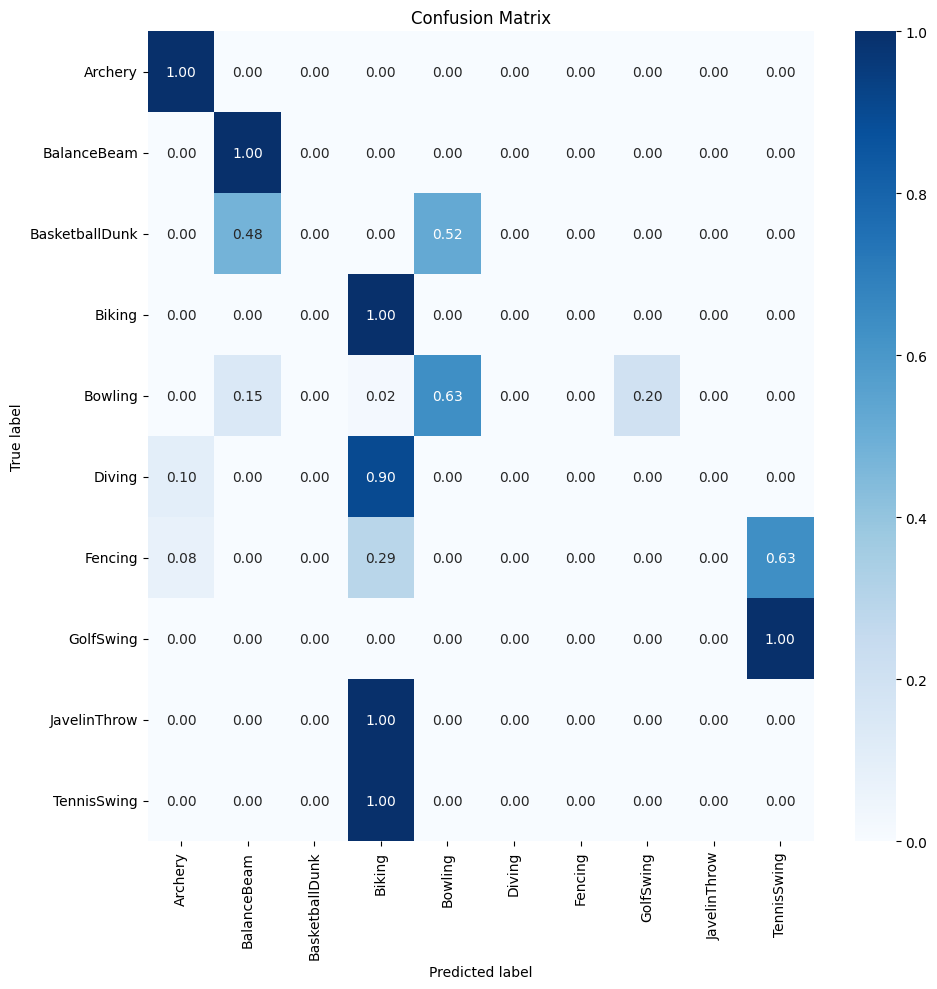

In [35]:
plot_confusion_matrix(all_labels, all_preds, ucf101.classes, normalize=True)

In [36]:
del(alex_net_model)

### Human Masking

In [19]:
alex_net_model_human_mask = AlexNet3D((frames_per_clip, height, width), len(ucf101.classes)).to(device=DEVICE)
alex_net_model_human_mask.load_state_dict(torch.load('models/alex_net_human_mask_data.pth'))
alex_net_model_human_mask.train(False)

AlexNet3D(
  (max_pool): MaxPool3d(kernel_size=3, stride=2, padding=(1, 1, 1), dilation=1, ceil_mode=False)
  (conv1): Conv3d(3, 96, kernel_size=(5, 5, 5), stride=(2, 2, 2), padding=(3, 0, 0))
  (conv2): Conv3d(96, 256, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(3, 2, 2))
  (conv3): Conv3d(256, 384, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv4): Conv3d(384, 384, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv5): Conv3d(384, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (linear1): Linear(in_features=100352, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

In [20]:
all_preds = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in tqdm(ucf101.test_loader):
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)
        y_pred_prob = alex_net_model_human_mask(inputs)
        y_pred = torch.argmax(y_pred_prob, dim=1)
        # Store predictions and true labels
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Convert lists to tensors or numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

100%|██████████| 10/10 [02:49<00:00, 16.93s/it]


In [21]:
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')


print("Precision:", precision)
print("Recall:", recall)

Precision: 0.28199052132701424
Recall: 0.28199052132701424


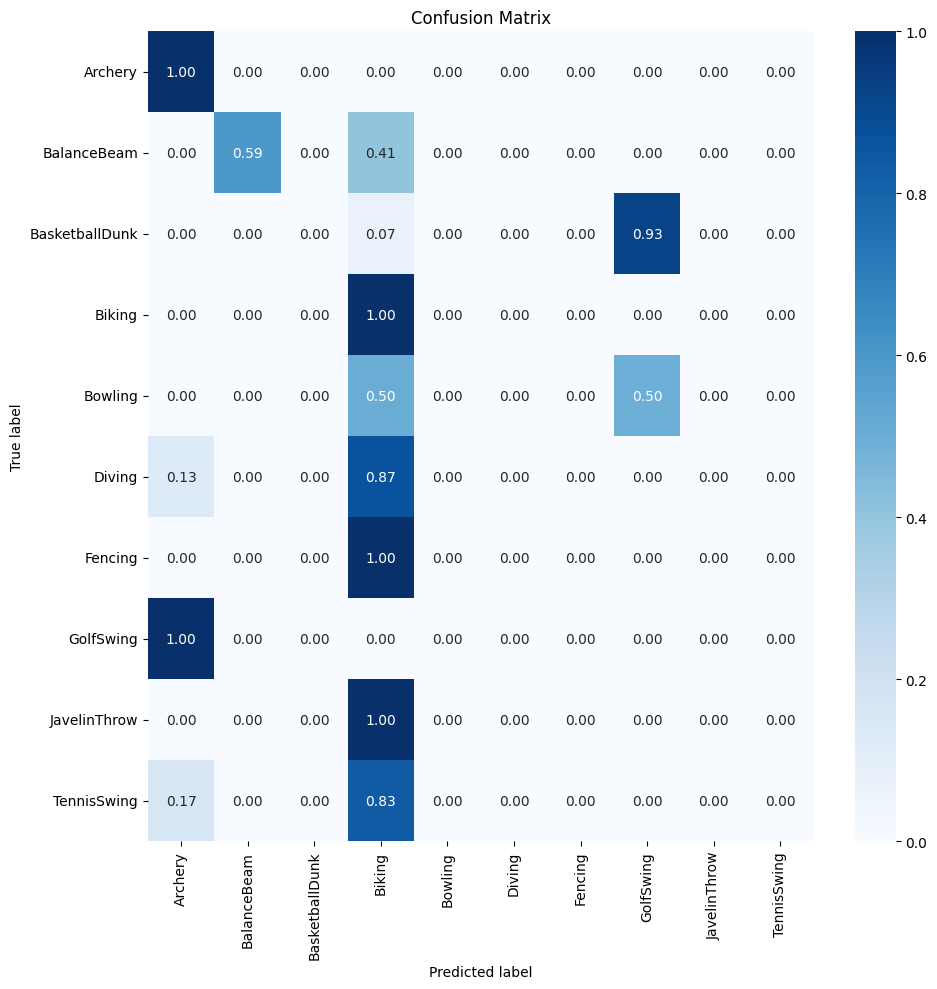

In [24]:
plot_confusion_matrix(all_labels, all_preds, ucf101.classes, normalize=True)

In [25]:
del(alex_net_model_human_mask)

### Background mask

In [27]:
alex_net_model_bg_mask = AlexNet3D((frames_per_clip, height, width), len(ucf101.classes)).to(device=DEVICE)
alex_net_model_bg_mask.load_state_dict(torch.load('models/alex_net_bg_mask_data.pth'))
alex_net_model_bg_mask.train(False)

AlexNet3D(
  (max_pool): MaxPool3d(kernel_size=3, stride=2, padding=(1, 1, 1), dilation=1, ceil_mode=False)
  (conv1): Conv3d(3, 96, kernel_size=(5, 5, 5), stride=(2, 2, 2), padding=(3, 0, 0))
  (conv2): Conv3d(96, 256, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(3, 2, 2))
  (conv3): Conv3d(256, 384, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv4): Conv3d(384, 384, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv5): Conv3d(384, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (linear1): Linear(in_features=100352, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=4096, bias=True)
  (linear3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

In [28]:
all_preds = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in tqdm(ucf101.test_loader):
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)
        y_pred_prob = alex_net_model_bg_mask(inputs)
        y_pred = torch.argmax(y_pred_prob, dim=1)
        # Store predictions and true labels
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Convert lists to tensors or numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

100%|██████████| 10/10 [02:51<00:00, 17.13s/it]


In [29]:
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')


print("Precision:", precision)
print("Recall:", recall)

Precision: 0.20616113744075829
Recall: 0.20616113744075829


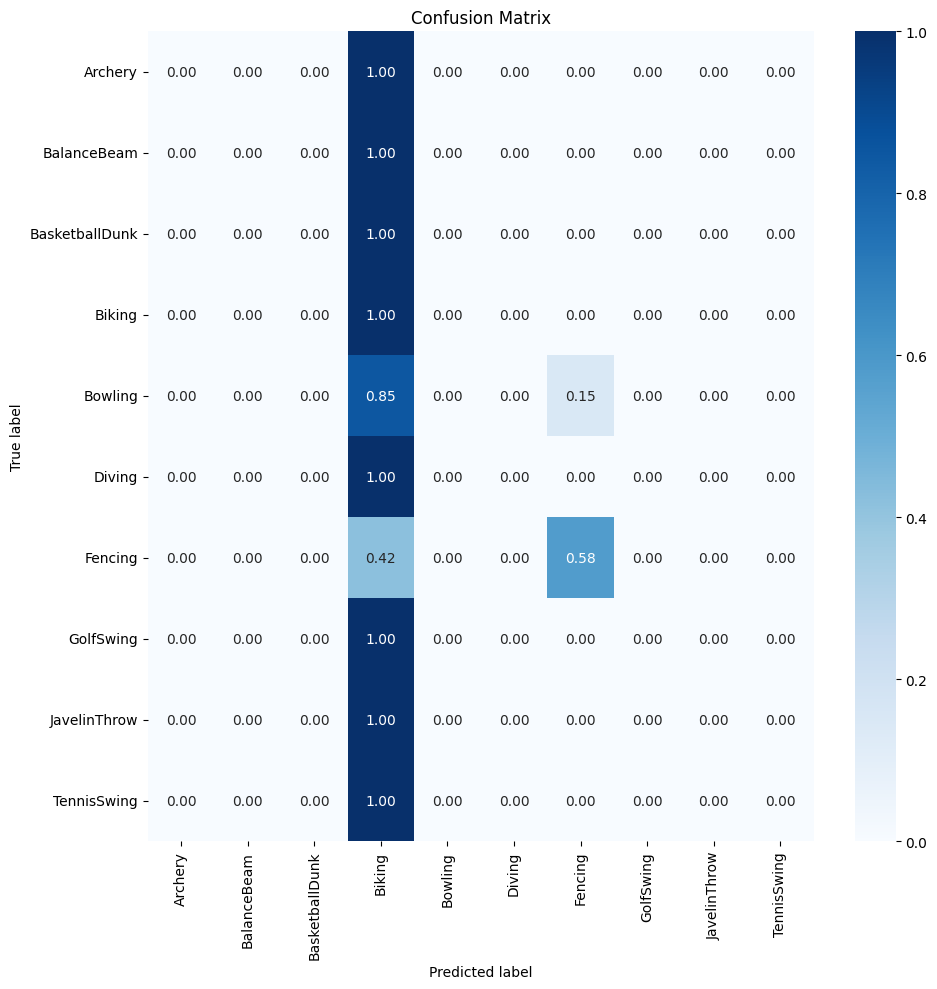

In [30]:
plot_confusion_matrix(all_labels, all_preds, ucf101.classes, normalize=True)

In [31]:
del(alex_net_model_bg_mask)

# VGG Model

In [3]:
ucf_data_dir = "data/UCF101/"
ucf_label_dir = "data/ucfTrainTestlist/"
frames_per_clip = 16
step_between_clips = 1

height = 64
width = 64

batch_size = 64

In [4]:
ucf101 = UCF101_Dataset_Loader(ucf_data_dir, ucf_label_dir, frames_per_clip, step_between_clips, height, width, batch_size)

Loading Training Data .........


100%|██████████| 85/85 [00:22<00:00,  3.81it/s]


Loading Testing Data .........


100%|██████████| 85/85 [00:22<00:00,  3.81it/s]



Total number of train samples: 6633
Total number of test samples: 2532
Total number of (train) batches: 104
Total number of (test) batches: 40


Total Number of Classes: 10


#### Without Mask

In [40]:
vgg_model = VGG3D((frames_per_clip, height, width), len(ucf101.classes)).to(device=DEVICE)
vgg_model.load_state_dict(torch.load('models/vgg_base_data.pth'))
vgg_model.train(False)

VGG3D(
  (max_pool): MaxPool3d(kernel_size=3, stride=2, padding=(1, 1, 1), dilation=1, ceil_mode=False)
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 0, 0))
  (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 2, 2))
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv4): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv5): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv6): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv7): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 4, 4))
  (conv8): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv9): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 4, 4))
  (conv10): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (linear1): Linear(i

In [41]:
all_preds = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in tqdm(ucf101.test_loader):
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)
        y_pred_prob = vgg_model(inputs)
        y_pred = torch.argmax(y_pred_prob, dim=1)
        # Store predictions and true labels
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Convert lists to tensors or numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

100%|██████████| 40/40 [03:08<00:00,  4.71s/it]


In [42]:
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')


print("Precision:", precision)
print("Recall:", recall)

Precision: 0.35268562401263825
Recall: 0.35268562401263825


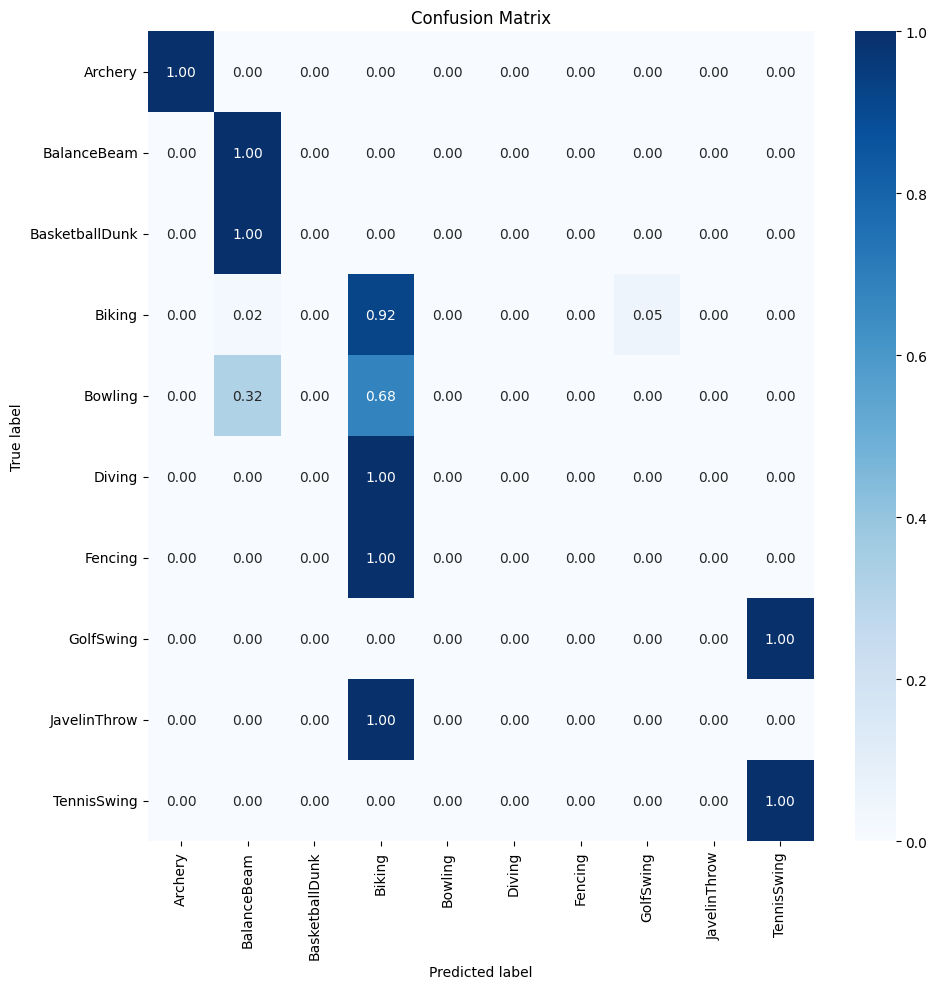

In [43]:
plot_confusion_matrix(all_labels, all_preds, ucf101.classes, normalize=True)

In [44]:
del(vgg_model)

### Human Masking

In [46]:
vgg_model_human_mask = VGG3D((frames_per_clip, height, width), len(ucf101.classes)).to(device=DEVICE)
vgg_model_human_mask.load_state_dict(torch.load('models/vgg_human_mask_data.pth'))
vgg_model_human_mask.train(False)

VGG3D(
  (max_pool): MaxPool3d(kernel_size=3, stride=2, padding=(1, 1, 1), dilation=1, ceil_mode=False)
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 0, 0))
  (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 2, 2))
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv4): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv5): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv6): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv7): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 4, 4))
  (conv8): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv9): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 4, 4))
  (conv10): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (linear1): Linear(i

In [47]:
all_preds = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in tqdm(ucf101.test_loader):
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)
        y_pred_prob = vgg_model_human_mask(inputs)
        y_pred = torch.argmax(y_pred_prob, dim=1)
        # Store predictions and true labels
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Convert lists to tensors or numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

100%|██████████| 40/40 [03:08<00:00,  4.72s/it]


In [48]:
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')


print("Precision:", precision)
print("Recall:", recall)

Precision: 0.23854660347551343
Recall: 0.23854660347551343


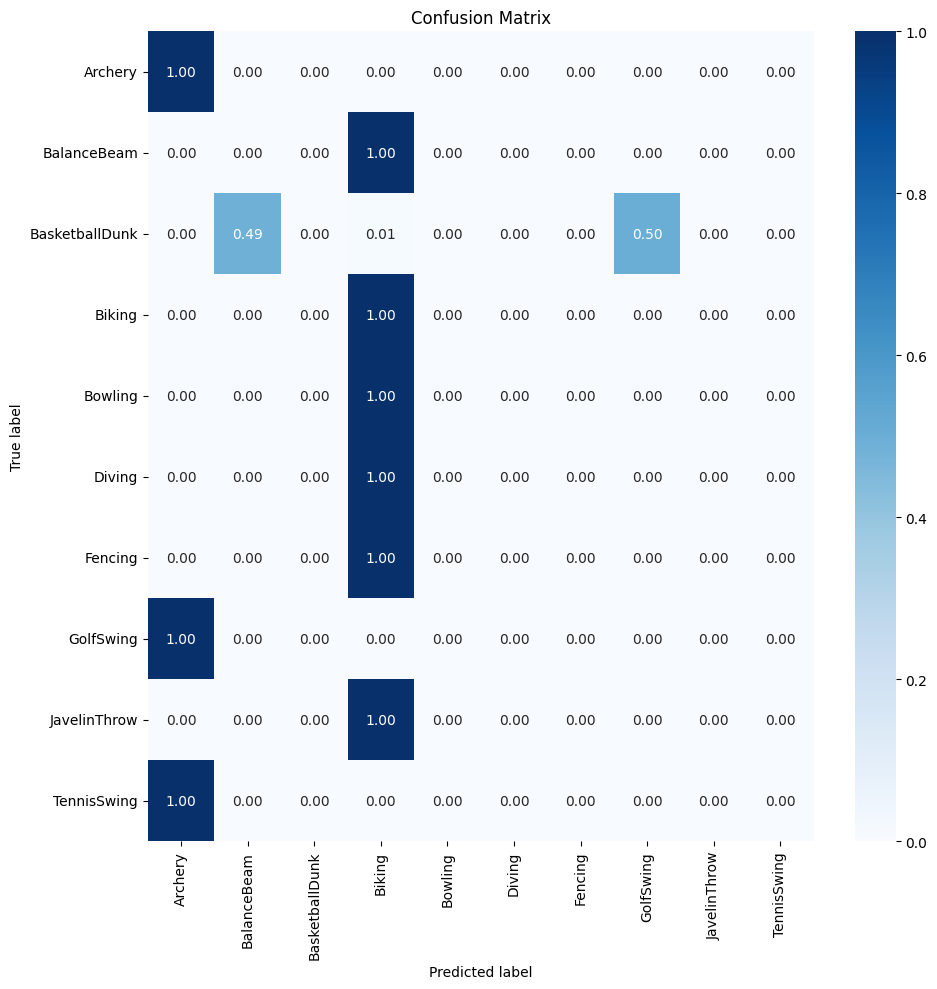

In [49]:
plot_confusion_matrix(all_labels, all_preds, ucf101.classes, normalize=True)

In [50]:
del(vgg_model_human_mask)

### Backgorund Mask

In [5]:
vgg_model_bg_mask = VGG3D((frames_per_clip, height, width), len(ucf101.classes)).to(device=DEVICE)
vgg_model_bg_mask.load_state_dict(torch.load('models/vgg_human_mask_data.pth'))
vgg_model_bg_mask.train(False)

VGG3D(
  (max_pool): MaxPool3d(kernel_size=3, stride=2, padding=(1, 1, 1), dilation=1, ceil_mode=False)
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 0, 0))
  (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 2, 2))
  (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv4): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv5): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv6): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv7): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 4, 4))
  (conv8): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (conv9): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 4, 4))
  (conv10): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (linear1): Linear(i

In [6]:
all_preds = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in tqdm(ucf101.test_loader):
        inputs = inputs.to(device=DEVICE)
        labels = labels.to(device=DEVICE)
        y_pred_prob = vgg_model_bg_mask(inputs)
        y_pred = torch.argmax(y_pred_prob, dim=1)
        # Store predictions and true labels
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


# Convert lists to tensors or numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

100%|██████████| 40/40 [03:11<00:00,  4.78s/it]


In [7]:
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')


print("Precision:", precision)
print("Recall:", recall)

Precision: 0.23854660347551343
Recall: 0.23854660347551343


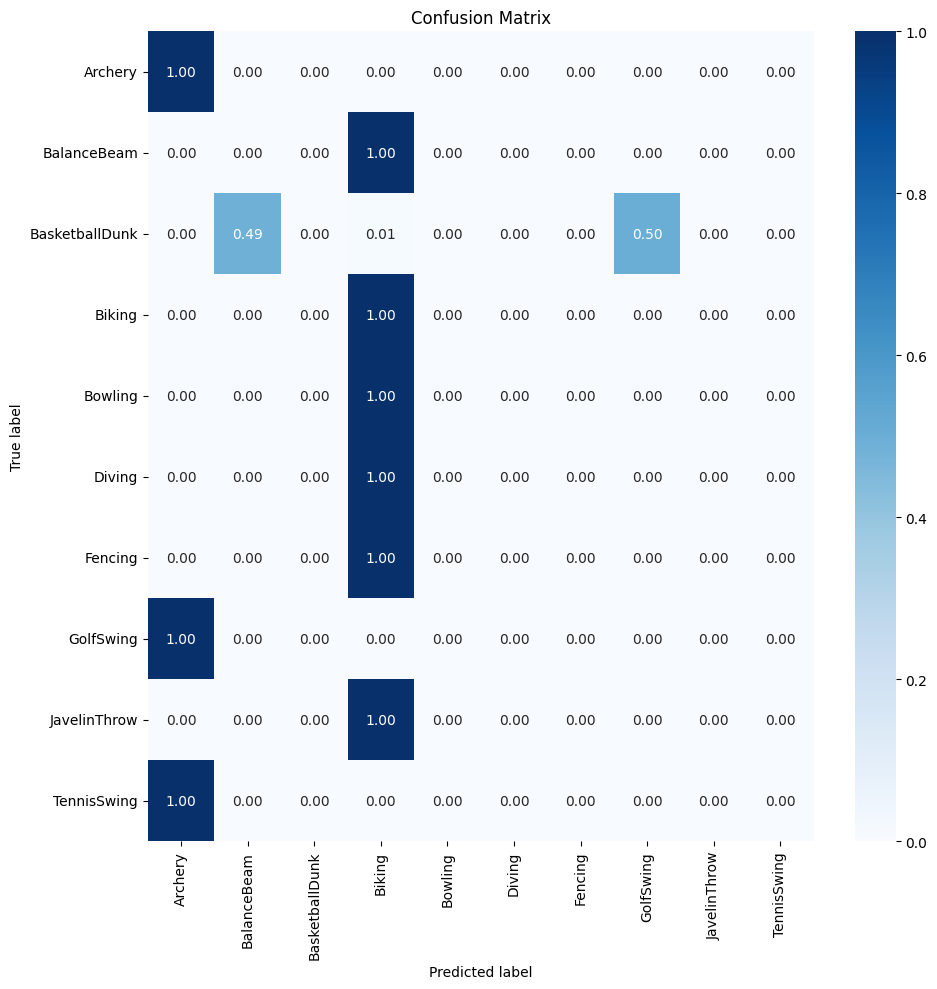

In [8]:
plot_confusion_matrix(all_labels, all_preds, ucf101.classes, normalize=True)

In [9]:
del(vgg_model_bg_mask)